<a href="https://colab.research.google.com/github/ShubhangiSRG24/SentimentAnalysis_DLmodel/blob/main/SentimentAnalysis_linkedinlearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers, models, losses, Sequential, optimizers, metrics

In [2]:
import tensorflow

print(tensorflow.__version__)

2.15.0


In [3]:
import keras

print(keras.__version__)

2.15.0


In [4]:
pip install seaborn -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [5]:
import seaborn as sns

print(sns.__version__)

0.13.2


In [6]:
tweets_data = pd.read_csv("Tweets.csv")

tweets_data.sample(10)

,textID,text,selected_text,sentiment
23503,a86dd8d290,Well it`s official I have strep,Well it`s official I have strep,neutral
25483,461402680c,mmm but nothing i can do. lucky ive got great...,great,positive
15935,258ed281c7,Just got to the hospital. Jimmys really bad......,worried.,negative
21636,88f94f7539,No dice...I searched it in the 'Help' area......,No dice...I searched it in the 'Help' area...j...,neutral
1633,08513f136b,Yeah it was great to be outside without rain/...,great,positive
4248,1e4bcc6393,"come home, then. Not so boring here.",so boring here.,negative
19264,91cd3bafff,hahahaha awww uduhn lun me no mor???,hahahaha awww uduhn lun me no mor???,neutral
27090,c3f7c0eb76,very malakas ang ulan. how will i go to fort,very malakas ang ulan. how will i go to fort,neutral
23477,ff1cb8b8bd,did you have fun last night? we didn`t see you.,did you have fun last night? we didn`t see you.,neutral
9240,459ed808cd,"Well, #Evernote is giving away Wireless SD car...","Well, #Evernote is giving away Wireless SD car...",neutral


In [7]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
tweets_data = tweets_data.dropna()

tweets_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [9]:
tweets_data.duplicated().sum()

0

In [10]:
#drop irrelevant columns
tweets_data = tweets_data.drop(columns = ["selected_text", "textID"])

tweets_data.sample(10)

,text,sentiment
10122,http://twitpic.com/4nbx4 - great photo! bravi...,positive
24482,"yes mate, on Friday",neutral
7819,Happy Mothers Day Mommy!!! I love you && your ...,positive
27008,So that is different than normal how?,neutral
10823,I`m glad you def needed a pick me up! drama...,positive
1925,You`ve got to have standards Alice otherwise ...,positive
26776,Parking garage concrete pole 1 -- the new Odes...,neutral
21042,I will have spent my allowance at cybernet ex...,positive
21255,I really miss Sebastian,negative
23059,yayy! i cant wait to see them!,neutral


In [11]:
tweets_data["sentiment"].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

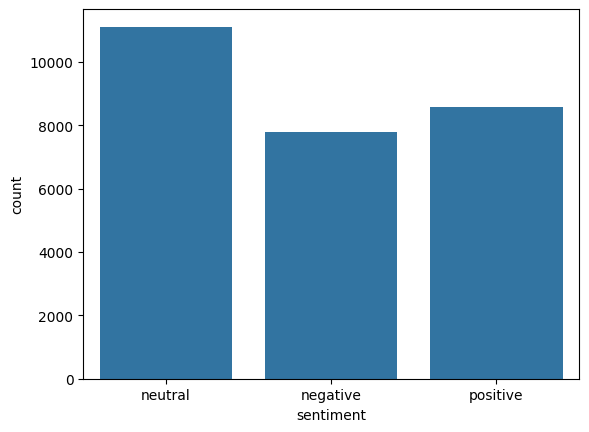

In [12]:
#graph of emotion counts
import seaborn as sns

sns.countplot(data = tweets_data, x = "sentiment")

In [13]:
#word count of each tweet instance
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))

tweets_data[["text", "word_count"]].sample(10)

,text,word_count
26446,excellent good to see,5
16557,"Ok, just noticed it is in theatres now - don...",19
9550,"and if you want to leaveeeee I can guranteee,...",17
874,"Aww, congrats to the family. ;) Send me picci...",13
11208,i cant wait to see you guys @ hq on sunday!!,12
10826,not good you`re not comin close to where i lo...,13
21526,"Man, the French Open has been on for a week an...",21
14093,wow. have a safe trip back home and we`re al...,24
750,Thanks! Welcome back!,4
7867,yes`ma... for an after party too after the sh...,12


In [14]:
#mean word count of each class:
tweets_data.groupby("sentiment")["word_count"].mean()

sentiment
negative    14.244313
neutral     13.207610
positive    14.100210
Name: word_count, dtype: float64

In [15]:
tweets_data.groupby("sentiment")["word_count"].median() #median is less prone to outliers

sentiment
negative    13.0
neutral     12.0
positive    13.0
Name: word_count, dtype: float64

<Axes: xlabel='word_count', ylabel='Count'>

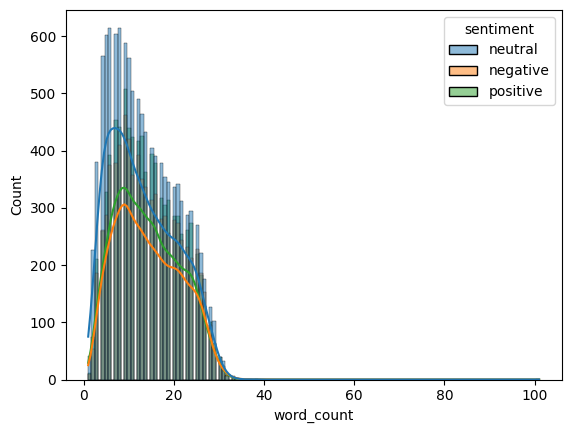

In [16]:
sns.histplot(data = tweets_data, x = "word_count", hue = "sentiment", kde = True)

<Axes: ylabel='word_count'>

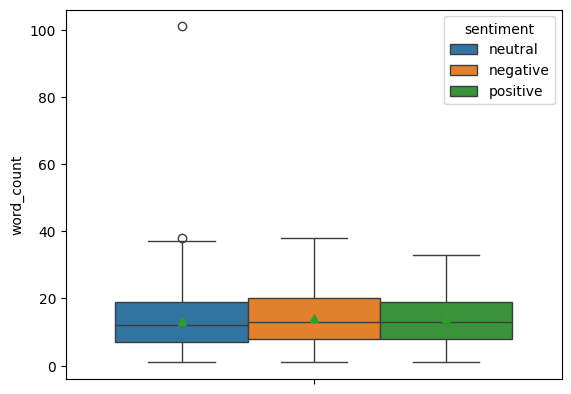

In [17]:
sns.boxplot(data = tweets_data, y = "word_count", hue = "sentiment", showmeans = True)

In [18]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
import string

def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [20]:
tweets_data["text"][5]

'http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth'

In [21]:
custom_standardization(tweets_data["text"][5]).numpy()

b'  shameless plugging best rangers forum earth'

In [22]:
tweets_data["text"][20]

' oh Marly, I`m so sorry!!  I hope you find her soon!! <3 <3'

In [23]:
custom_standardization(tweets_data["text"][20]).numpy()

b' oh marly  sorry hope find soon  '

In [24]:
tweets_data["text"][527]

'i am living in ignorance  :@'

In [25]:
custom_standardization(tweets_data["text"][527]).numpy()

b' living ignorance '

In [26]:
tweets_data["text"][11827]

'My Degree  [Tear] happy moment!  http://mypict.me/1ZpF'

In [27]:
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

In [28]:
tweets_data["cleaned_text"] = tweets_data["text"].apply(custom_standardization)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [29]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")  # Assuming utf-8 encoding

# Apply the function to the DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,8,worth


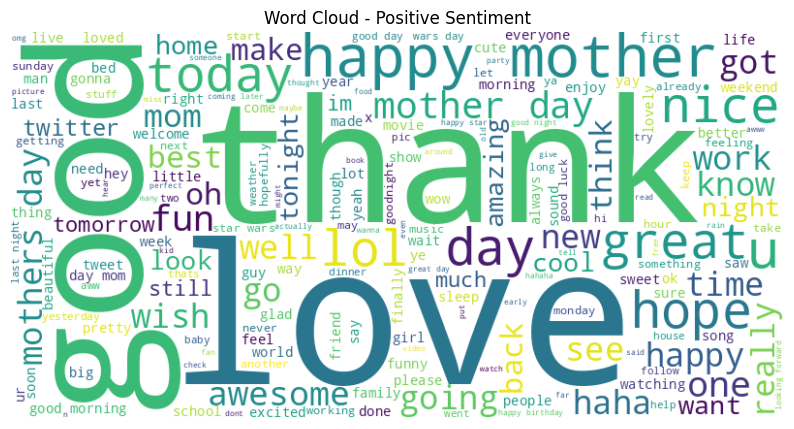

In [30]:
# Extract the text from positive sentiment tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all the positive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(positive_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

In [31]:
tweets_data["sentiment"] = tweets_data["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2})

tweets_data.sample(10)

,text,sentiment,word_count,cleaned_text
5798,Gonna go to my aunts party. It`s gonna be a la...,1,22,gonna go aunts party gonna late night thing h...
12487,With my jordie for a little bit,1,7,jordie little bit
18726,"this is 5 hours late, but i never managaed to...",1,24,hours late never managaed sleep properly thin...
5250,mom said no.,1,4,mom said
21143,_Reid Lol. It was the dissing of the were-octo...,1,23,reid lol dissing octopus however redeems resc...
5716,TINK! (whatever the **** it means!!) from you...,2,18,tink whatever means jkuk girls show us love
11432,"Holy **** it`s super sunny, Friday and Whitsun...",0,18,holy super sunny friday whitsun tube deeeese...
4019,Had a great weekend with John-back to work for...,2,24,great weekend johnback work days going illino...
14470,"Aaaagh, aircon not working in my office",0,7,aaaagh aircon working office
11495,oh good luck on the movie,2,7,oh good luck movie


In [32]:
#StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set.
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size = 0.2, stratify = tweets_data["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

((19785, 4), (2199, 4), (5496, 4))

In [33]:
X_train["sentiment"].value_counts()

1    8005
2    6178
0    5602
Name: sentiment, dtype: int64

In [34]:
X_val["sentiment"].value_counts()

1    889
2    687
0    623
Name: sentiment, dtype: int64

In [35]:
X_test["sentiment"].value_counts()

1    2223
2    1717
0    1556
Name: sentiment, dtype: int64

In [36]:
#Creating Training and validation dataset from corresponding pandas dataframes

raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

(155, 18, 43)

In [37]:
#small eg of count vectorizer
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "count",
)

In [38]:
# list of text documents
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [39]:
count_vectorizer.adapt(text)

In [40]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [41]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [42]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

In [43]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

In [44]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

In [45]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

Tweet:  tf.Tensor(b', Decaf? I can do some teas late but never coffee- Id fly around the room. Justin Timberlake hosted. FUNNY sketch w/ Samberg', shape=(), dtype=string)
Sentiment:  positive
Vectorized review:  (<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=
array([[17.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
     

In [46]:
count_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

In [47]:
vocab_size =  len(count_vectorizer.get_vocabulary())

vocab_size

10000

In [48]:
print("40   ---> ", count_vectorizer.get_vocabulary()[40])
print("80   ---> ", count_vectorizer.get_vocabulary()[80])
print("160  ---> ", count_vectorizer.get_vocabulary()[160])

40   --->  fun
80   --->  yes
160  --->  someone


In [49]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [51]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [52]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 642243 (2.45 MB)
Trainable params: 642243 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds)

Epoch 1/10
155/155 [==============================] - 7s 36ms/step - loss: 1.0752 - accuracy: 0.4393 - val_loss: 1.0401 - val_accuracy: 0.4930
Epoch 2/10
155/155 [==============================] - 3s 21ms/step - loss: 0.9967 - accuracy: 0.5582 - val_loss: 0.9673 - val_accuracy: 0.5753
Epoch 3/10
155/155 [==============================] - 4s 28ms/step - loss: 0.9005 - accuracy: 0.6411 - val_loss: 0.8901 - val_accuracy: 0.6276
Epoch 4/10
155/155 [==============================] - 3s 21ms/step - loss: 0.8027 - accuracy: 0.6964 - val_loss: 0.8292 - val_accuracy: 0.6644
Epoch 5/10
155/155 [==============================] - 5s 33ms/step - loss: 0.7190 - accuracy: 0.7352 - val_loss: 0.7899 - val_accuracy: 0.6808
Epoch 6/10
155/155 [==============================] - 3s 21ms/step - loss: 0.6526 - accuracy: 0.7584 - val_loss: 0.7687 - val_accuracy: 0.6839
Epoch 7/10
155/155 [==============================] - 4s 29ms/step - loss: 0.5994 - accuracy: 0.7781 - val_loss: 0.7610 - val_accuracy: 0.6889

In [54]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

43/43 [==============================] - 1s 24ms/step - loss: 0.7936 - accuracy: 0.6796
Loss:  0.7936229705810547
Accuracy:  0.6795851588249207


In [55]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [56]:
history_dict

{'loss': [1.075163722038269,
  0.9966527819633484,
  0.9004991054534912,
  0.8027223348617554,
  0.719002902507782,
  0.6525676846504211,
  0.5993786454200745,
  0.5554254651069641,
  0.5174643993377686,
  0.48392632603645325],
 'accuracy': [0.4392721652984619,
  0.5582006573677063,
  0.6411423087120056,
  0.6963861584663391,
  0.7351529002189636,
  0.7584028244018555,
  0.7781147360801697,
  0.795198380947113,
  0.8146070241928101,
  0.8265857696533203],
 'val_loss': [1.0401440858840942,
  0.9673095941543579,
  0.8900517821311951,
  0.8292240500450134,
  0.7899317741394043,
  0.7687407732009888,
  0.7609811425209045,
  0.7613994479179382,
  0.7680616974830627,
  0.7796462774276733],
 'val_accuracy': [0.49295133352279663,
  0.5752614736557007,
  0.6275579929351807,
  0.66439288854599,
  0.6807639598846436,
  0.6839472651481628,
  0.6889495253562927,
  0.6898590326309204,
  0.6907685399055481,
  0.6907685399055481]}

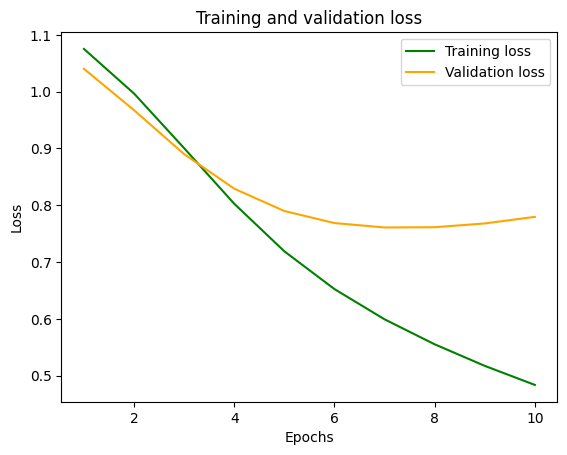

In [57]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

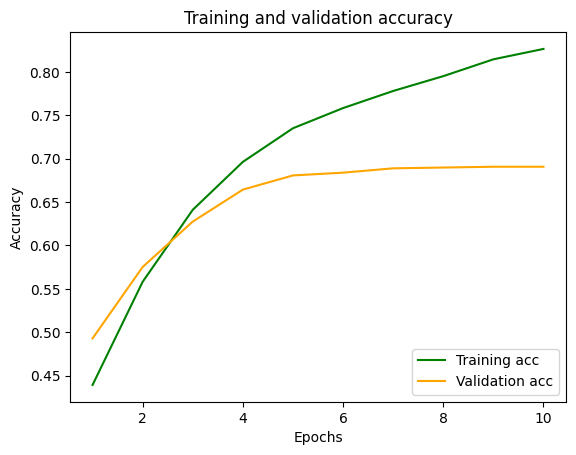

In [58]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [59]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

43/43 [==============================] - 1s 12ms/step - loss: 0.7936 - accuracy: 0.6796
0.6795851588249207


In [60]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

172/172 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1556
           1       0.63      0.70      0.67      2223
           2       0.73      0.71      0.72      1717

    accuracy                           0.68      5496
   macro avg       0.69      0.68      0.68      5496
weighted avg       0.68      0.68      0.68      5496



In [61]:
#TFIDF tensor vectorizer
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [62]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [63]:
tfidf_vectorizer.adapt(text)

In [64]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'painter',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [65]:
tfidf_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0.        , 0.6931472 , 1.6945957 , 0.        , 0.        ,
        1.0986123 , 0.        , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 , 1.0986123 , 1.0986123 ],
       [0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.0986123 , 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.6931472 , 0.84729785, 0.84729785, 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        0.        , 0

In [66]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

In [67]:
tfidf_vectorizer.get_vocabulary()

['[UNK]',
 'day',
 'good',
 'get',
 'like',
 'go',
 'today',
 'love',
 'going',
 'work',
 'got',
 'one',
 'time',
 'lol',
 'know',
 'happy',
 'u',
 'really',
 'back',
 'im',
 'see',
 'night',
 'new',
 'home',
 'think',
 'want',
 'well',
 'oh',
 'much',
 'still',
 'thanks',
 'miss',
 'great',
 'last',
 'need',
 'morning',
 'haha',
 'hope',
 'would',
 'feel',
 'fun',
 'tomorrow',
 'sorry',
 'twitter',
 'wish',
 'bad',
 'make',
 'tonight',
 'sad',
 'right',
 'week',
 'yeah',
 'nice',
 'way',
 'mother',
 'gonna',
 'though',
 'better',
 'sleep',
 'could',
 'weekend',
 'come',
 'next',
 'people',
 'bed',
 'getting',
 'mothers',
 'wait',
 'watching',
 'mother day',
 'hate',
 'days',
 'say',
 'awesome',
 'thing',
 'school',
 'dont',
 'even',
 'mom',
 'soon',
 'yes',
 'long',
 'little',
 'show',
 'best',
 'working',
 'sure',
 'never',
 'ok',
 'thank',
 'done',
 'mothers day',
 'tired',
 'hey',
 'cool',
 'feeling',
 'take',
 'cant',
 'happy mother',
 'everyone',
 'look',
 'first',
 'please',
 'l

In [68]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

In [69]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [70]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [71]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

Epoch 1/40
155/155 [==============================] - 8s 41ms/step - loss: 1.1570 - accuracy: 0.3469 - val_loss: 1.1119 - val_accuracy: 0.3743
Epoch 2/40
155/155 [==============================] - 4s 25ms/step - loss: 1.1080 - accuracy: 0.3876 - val_loss: 1.0832 - val_accuracy: 0.4243
Epoch 3/40
155/155 [==============================] - 3s 21ms/step - loss: 1.0843 - accuracy: 0.4163 - val_loss: 1.0665 - val_accuracy: 0.4488
Epoch 4/40
155/155 [==============================] - 4s 28ms/step - loss: 1.0635 - accuracy: 0.4484 - val_loss: 1.0515 - val_accuracy: 0.4711
Epoch 5/40
155/155 [==============================] - 3s 21ms/step - loss: 1.0446 - accuracy: 0.4638 - val_loss: 1.0374 - val_accuracy: 0.4870
Epoch 6/40
155/155 [==============================] - 6s 39ms/step - loss: 1.0261 - accuracy: 0.4935 - val_loss: 1.0238 - val_accuracy: 0.5075
Epoch 7/40
155/155 [==============================] - 4s 27ms/step - loss: 1.0072 - accuracy: 0.5152 - val_loss: 1.0104 - val_accuracy: 0.5184

In [ ]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [ ]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]